In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils

### 1. Load the speech file speech1.wav.

In [2]:
speech = AudioSignal(os.path.join(os.getcwd(), '../Exercise3', 'AudioFiles', 'speech1.wav'))

Successfully loaded audio signal from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise3/AudioFiles/speech1.wav


### 2. Select one unvoiced and one voiced speech segment from the signal, each with a length of 32 ms.

In [3]:
frame_centers_ms, frames = speech.get_frames(32, 32)

In [4]:
hann = ss.get_window('hann', utils.ms_to_idx(32, 16000))

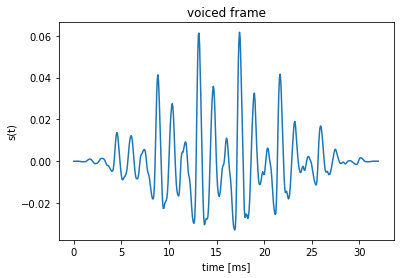

In [5]:
voiced_frame_idx = 13 # np.where(frame_centers_ms == 400)[0][0]
voiced_frame = frames[voiced_frame_idx] * hann

t = np.linspace(0, 32, 512)
fix, ax = plt.subplots()
ax.set_title("voiced frame")
ax.set_xlabel("time [ms]")
ax.set_ylabel("s(t)")
ax.plot(t, voiced_frame)

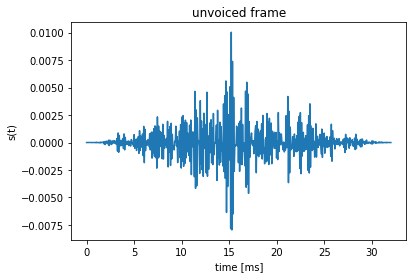

In [6]:
unvoiced_frame_idx = np.where(frame_centers_ms == 560)[0][0]
unvoiced_frame = frames[unvoiced_frame_idx] * hann

t = np.linspace(0, 32, 512)
fix, ax = plt.subplots()
ax.set_title("unvoiced frame")
ax.set_xlabel("time [ms]")
ax.set_ylabel("s(t)")
ax.plot(t, unvoiced_frame)

### 3. Compute the M = 12-order LP coefficients

In [7]:
def auto_correlate(frame:np.array):
    return np.correlate(frame, frame,'full')

def compute_phi(frame: np.array, m:int =12):
    acf = auto_correlate(frame)
    phi_start = len(acf) // 2
    phi_end = phi_start + m
    phi = acf[phi_start:phi_end + 1]
    assert len(phi) == m+1, f"len(phi)={len(phi)} != m+1={m+1}"
    return phi

def compute_lpc(frame: np.array, m:int=12):
    phi = compute_phi(frame, m)
    c = phi[:-1]
    r = phi[:-1]
    b = phi[1:]
    a = sl.solve_toeplitz((-c,-r), b)
    assert len(a) == m
    return a 

In [8]:
lpc_voiced = compute_lpc(voiced_frame, m=12)
lpc_unvoiced = compute_lpc(unvoiced_frame, m=12)

### 4. a) Make a plot of the frequency response (amplitude as well as phase) of the estimated vocal tract filter

In [9]:
def compute_complex_filter_response(lpc: np.array, n:int=512, fs:int=16000) -> np.ndarray:
    return ss.freqz(1, np.concatenate(([1], lpc)), n, whole=True, fs=fs)

In [10]:
fresp_voiced = compute_complex_filter_response(lpc_voiced, len(voiced_frame), speech.sampling_freq)
fresp_unvoiced = compute_complex_filter_response(lpc_unvoiced, len(unvoiced_frame), speech.sampling_freq)

In [11]:
def plot_filter_response(fresp: np.ndarray, frame_name:str = None):
    w, h = fresp
    fig, ax1 = plt.subplots( figsize=(10, 5))
    ax1.set_title('Digital filter frequency response: %s' % frame_name)
    ax1.plot(w, 10 * np.log10(np.abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [Hz]')
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

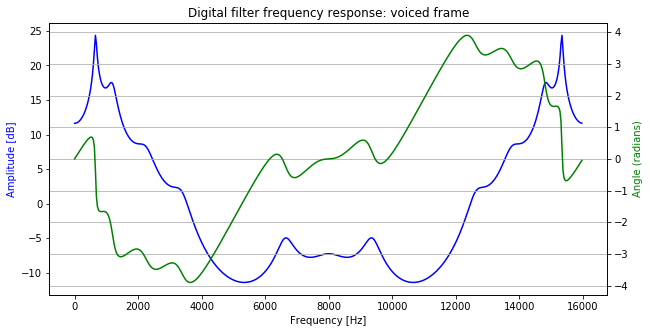

In [12]:
plot_filter_response(fresp_voiced, "voiced frame")

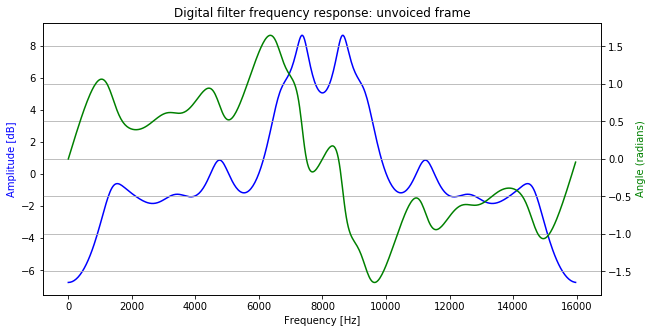

In [13]:
plot_filter_response(fresp_unvoiced, "unvoiced frame")

### 5. Compute the discrete Fourier transform (DFT) of the windowed segments

In [14]:
dft_voiced = np.fft.rfft(voiced_frame)
dft_unvoiced = np.fft.rfft(unvoiced_frame)

In [15]:
def plot_dft_with_vocal_tract_filter_response(frame: np.array, frame_name:str, m_lpc:int = 12, fs: int = 16000, b0=1, plot=None):
    lpc = compute_lpc(frame, m=m_lpc)
    fresp = compute_complex_filter_response(lpc, len(frame), fs)
    dft = np.fft.rfft(frame)
    
    w, h = fresp
    h = h * b0
    
    # setup plot 
    if plot is None:
        fig, ax1 = plt.subplots(figsize=(20, 10))
    else:
        fig, ax1 = plot
        
    ax1.set_ylabel('Amplitude [dB]')
    ax1.set_xlabel('Frequency [Hz]')
    
    # plot dft amplitude
    if plot is None:
        ax1.plot(w[:dft.shape[0]], 10 * np.log10(np.abs(dft)), label="DFT of s(n)")
    
    # plot filter response amplitude
    ax1.plot(w[:dft_voiced.shape[0]], 10 * np.log10(np.abs(h[:dft_voiced.shape[0]])), label=f"H(z) with M={m_lpc}")
    
    ax1.legend()
    
    return fig, ax1
    

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbfb696630>)

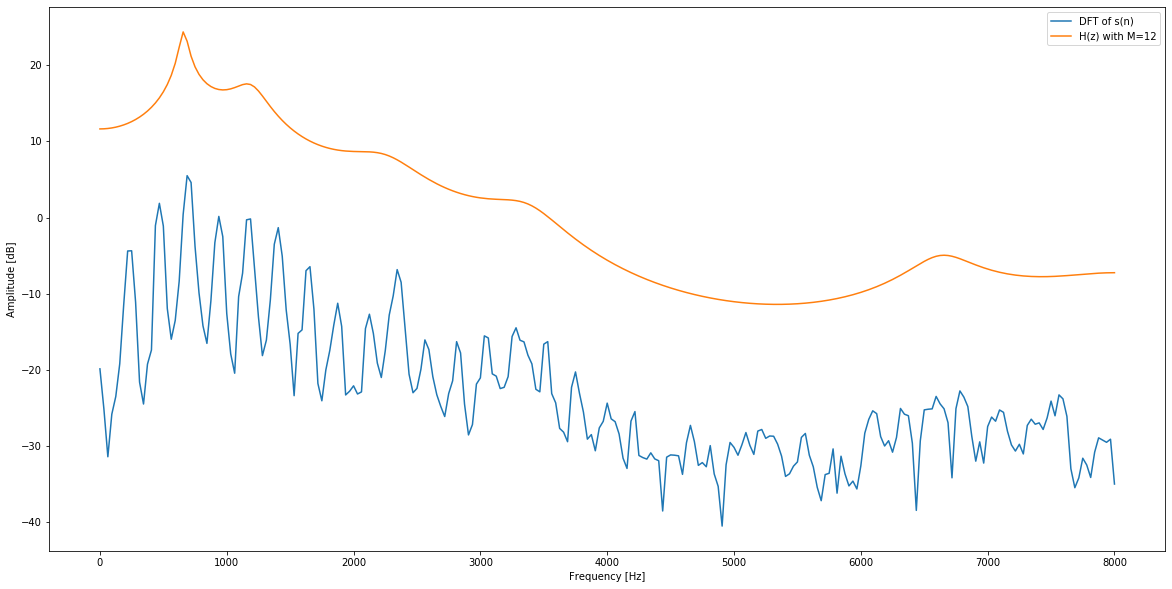

In [16]:
plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame")

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbfb0f5ac8>)

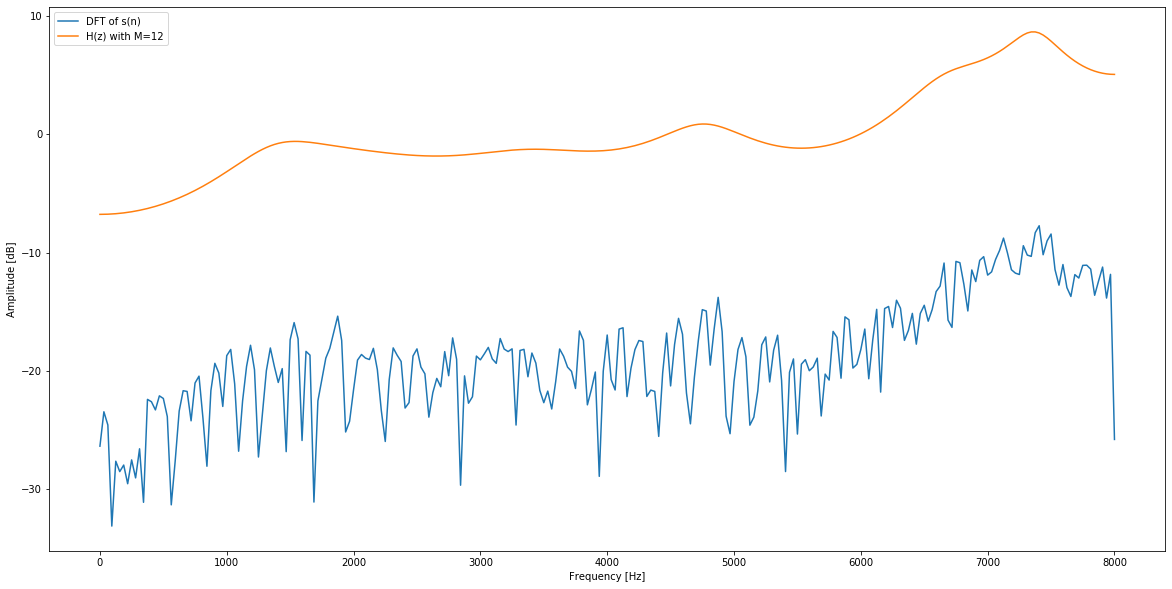

In [17]:
plot_dft_with_vocal_tract_filter_response(unvoiced_frame, "unvoiced frame")

### 6.a) For both segments, compute the residual signal by using the inverse filtering statement

In [18]:
def compute_residual_signal(lpc: np.array, frame: np.array):
    return ss.lfilter(np.concatenate(([1], lpc)), 1, frame)

In [19]:
res_voiced = compute_residual_signal(lpc_voiced, voiced_frame)
res_unvoiced = compute_residual_signal(lpc_unvoiced, unvoiced_frame)

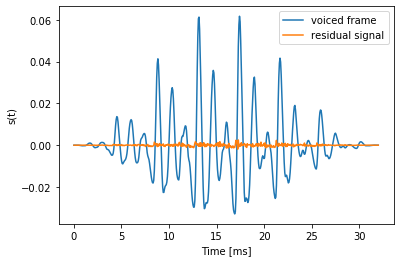

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("s(t)")

t = np.linspace(0, speech.idx_to_ms(len(voiced_frame)), len(voiced_frame))
ax.plot(t, voiced_frame, label='voiced frame')
ax.plot(t, res_voiced, label='residual signal')
ax.legend()

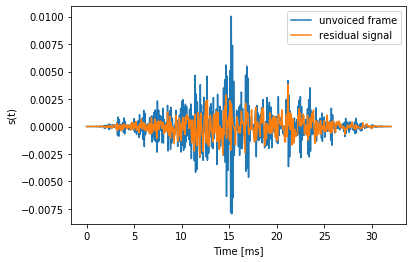

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("s(t)")

t = np.linspace(0, speech.idx_to_ms(len(unvoiced_frame)), len(unvoiced_frame))
ax.plot(t, unvoiced_frame, label='unvoiced frame')
ax.plot(t, res_unvoiced, label='residual signal')
ax.legend()

### 7.b) How can you modify H to achieve a better match? Hint: Experiment with the energy of the residual e.

In [22]:
def compute_energy_in_time_domain(s: np.ndarray):
    return np.sum(s ** 2)

def compute_energy_in_freq_domain(S: np.ndarray):
    return np.sum(np.abs(S) ** 2) / len(S)

In [23]:
energy_res_voiced = compute_energy_in_time_domain(res_voiced)
energy_res_unvoiced = compute_energy_in_time_domain(res_unvoiced)
print(energy_res_voiced)
print(energy_res_unvoiced)

0.00012040269333015471
0.00028416275806287335


In [24]:
energy_seg_voiced = compute_energy_in_time_domain(voiced_frame)
energy_seg_unvoiced = compute_energy_in_time_domain(unvoiced_frame)
print(energy_seg_voiced)
print(energy_seg_unvoiced)

0.11963645606394929
0.001400322011849788


In [25]:
energy_fresp_voiced = compute_energy_in_freq_domain(fresp_voiced)
energy_fresp_unvoiced = compute_energy_in_freq_domain(fresp_unvoiced)
print(energy_fresp_voiced)
print(energy_fresp_unvoiced)

21781630271.97495
21781376261.539078


(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbfb421630>)

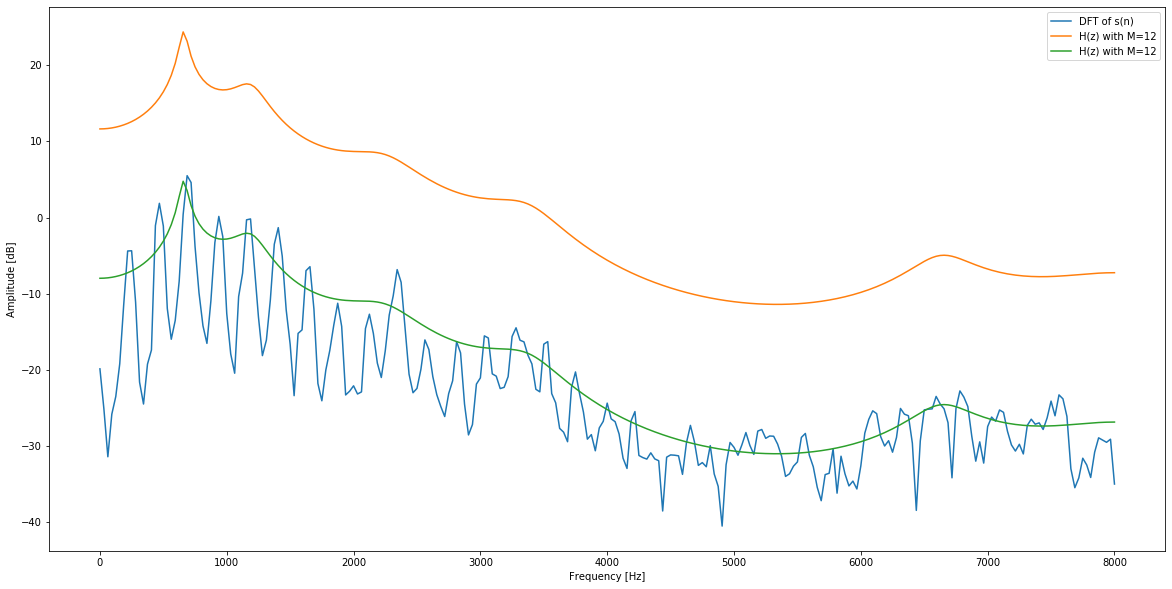

In [26]:
fig, ax = plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame", b0=1, plot=None)
plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame", b0=np.sqrt(energy_res_voiced), plot=(fig, ax))

 ### 8. Play with the order of the predictor (M = 2 · · · 20). Describe differences in H(z) and explain reasons for that.

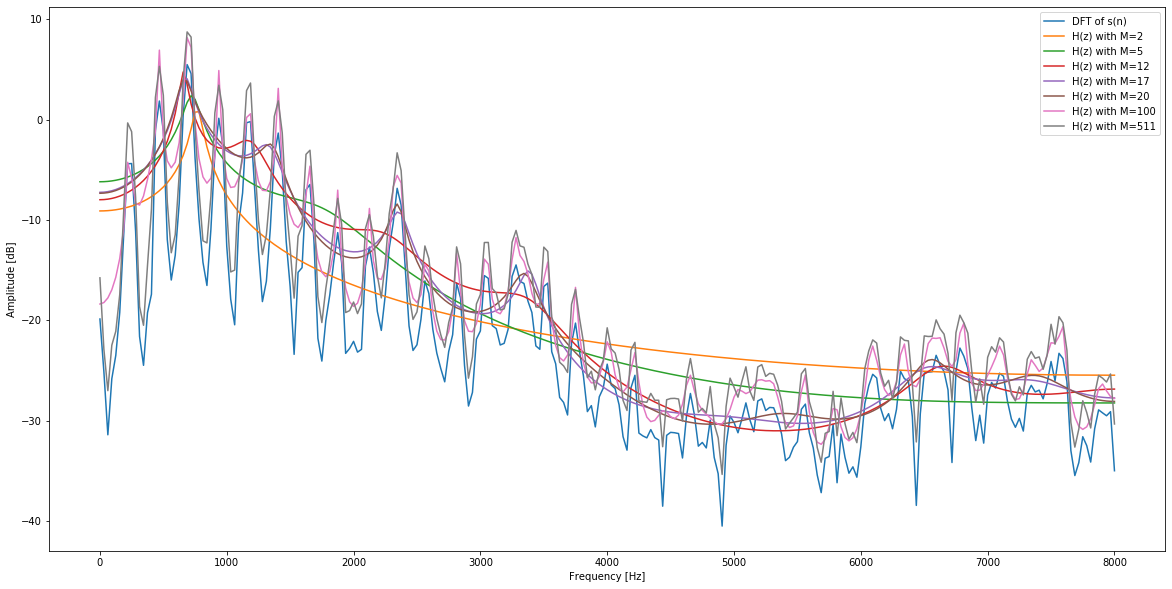

In [27]:
fig, ax = plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame", b0=np.sqrt(energy_res_voiced), m_lpc=2, plot=None)
for m in [5, 12, 17, 20, 100, 511]:
    plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame", b0=np.sqrt(energy_res_voiced), m_lpc=m, plot=(fix, ax))

### 9. From the speech production model it is known that speech undergoes a spectral tilt of −6 dB/octave. To counteract this effect, a pre-emphasis filter of the following form is used

In [28]:
def pre_emphasize(s: np.ndarray, alpha: np.float32 = .95):
    return ss.lfilter(np.array([1, -alpha]), 1, s)

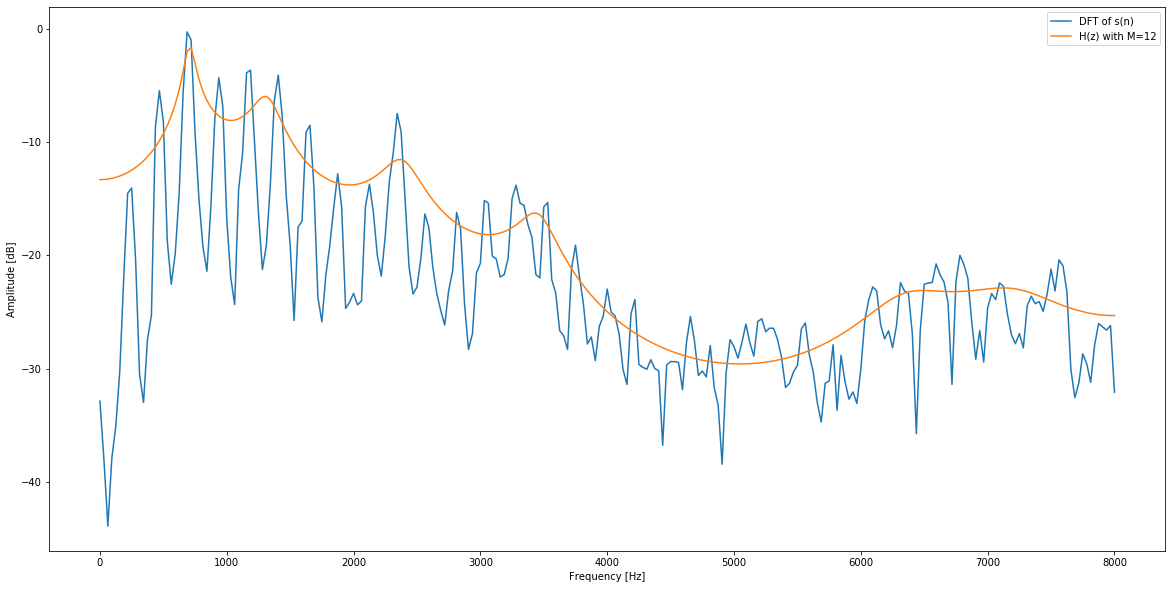

In [29]:
fig, ax = plot_dft_with_vocal_tract_filter_response(pre_emphasize(voiced_frame), "voiced frame", b0=np.sqrt(energy_res_voiced))

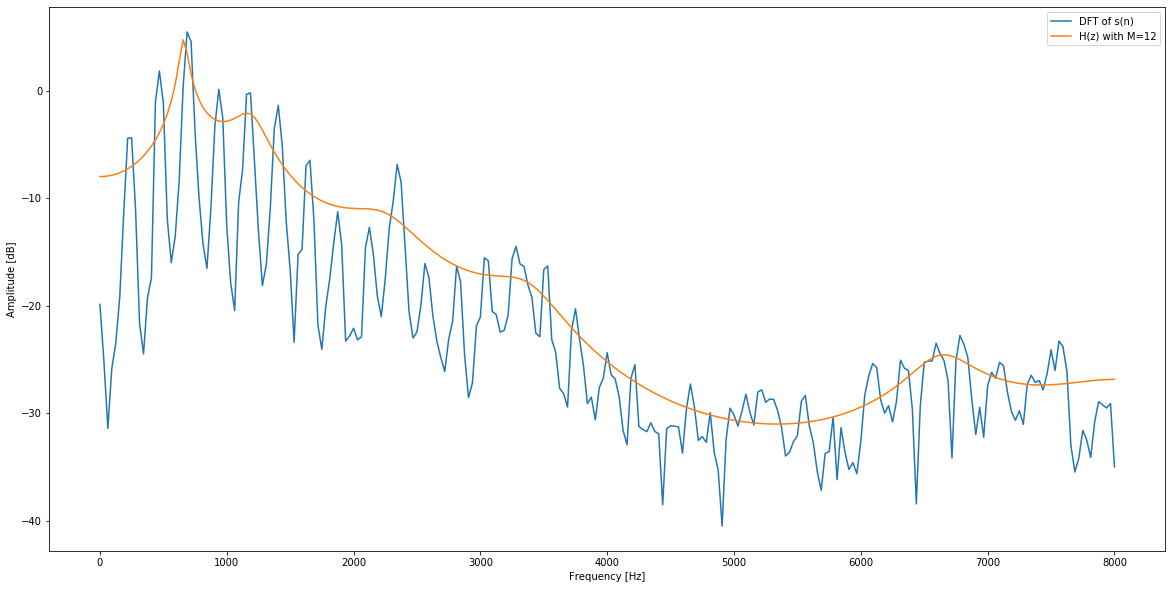

In [30]:
fig, ax = plot_dft_with_vocal_tract_filter_response(voiced_frame, "voiced frame", b0=np.sqrt(energy_res_voiced))

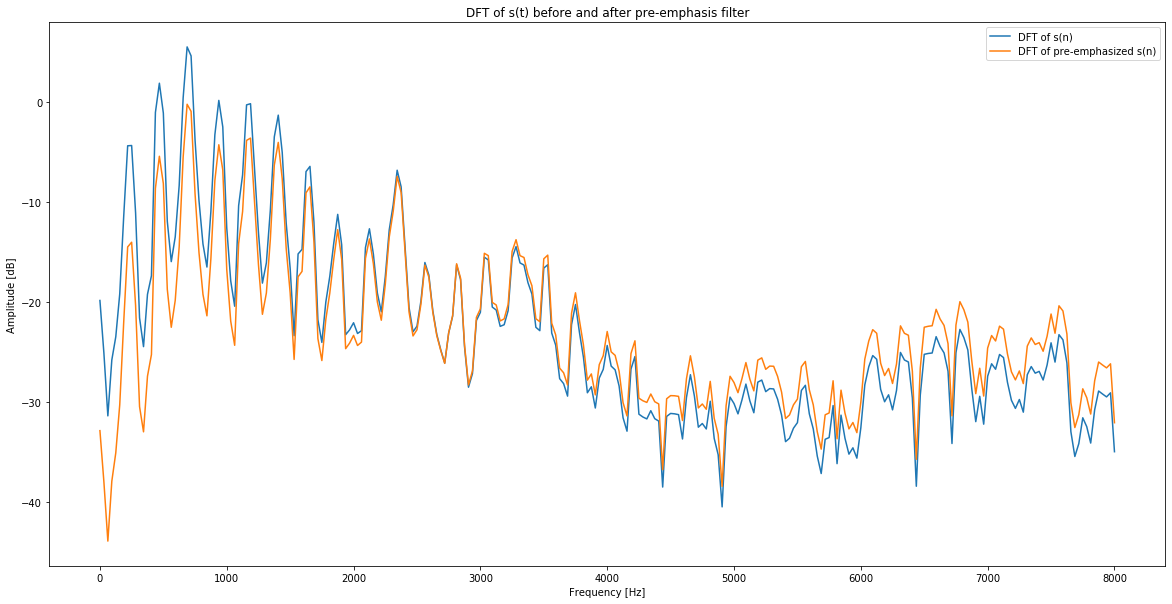

In [31]:
dft_voiced_pre_emp = np.fft.rfft(pre_emphasize(voiced_frame))

fig, ax1 = plt.subplots( figsize=(20, 10))
ax1.set_title('DFT of s(t) before and after pre-emphasis filter')
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [Hz]')

f = np.fft.rfftfreq(512, 1./16000);

ax1.plot(f, 10 * np.log10(np.abs(dft_voiced)), label='DFT of s(n)')
ax1.plot(f, 10 * np.log10(np.abs(dft_voiced_pre_emp)), label='DFT of pre-emphasized s(n)')
ax1.legend()

In [32]:
c = auto_correlate(frames)

ValueError: object too deep for desired array